## **GoogLeNet very deep convolutional Model**

### **1.Installing and importing requirements**

In [1]:
!nvidia-smi # checking nvidia system managment interface

Tue May 10 21:23:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
import time
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix
from tqdm.autonotebook import tqdm
from torchsummary import summary

### **2.HyperParameters**


In [23]:
# Hyperparameters
RANDOM_SEED = 42
LEARNING_RATE = 1e-2
BATCH_SIZE = 128
NUM_EPOCHS = 10

# Architecture
NUM_CLASSES = 10

# Other
DEVICE = "cuda:0"
GRAYSCALE = False

In [24]:
torch.manual_seed(RANDOM_SEED)

In [25]:
from numpy.core.fromnumeric import resize
transform_train = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    ])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    ])


train_ds = datasets.CIFAR10(root='data', 
                               train=True, 
                               transform=transform_train,
                               download=True)
train_set, val_set = torch.utils.data.random_split(train_ds, [45000, 5000])

test_ds = datasets.CIFAR10(root='data', 
                              train=False, 
                              transform=transform_test)


train_loader = DataLoader(dataset=train_set,
                          batch_size=BATCH_SIZE,
                      shuffle = True)


val_loader = DataLoader(dataset=val_set,
                          batch_size=BATCH_SIZE,
                      shuffle = False)

test_loader = DataLoader(dataset=test_ds,
                     batch_size=BATCH_SIZE,
                     shuffle = False)

# Checking the dataset
images, labels = next(iter(train_loader))  
print('Image batch dimensions:', images.shape)
print('Image label dimensions:', labels.shape)

Files already downloaded and verified
Image batch dimensions: torch.Size([128, 3, 224, 224])
Image label dimensions: torch.Size([128])


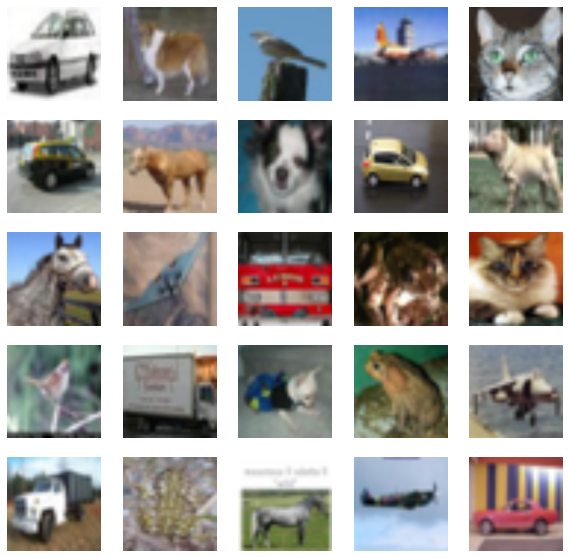

In [26]:
features, targets = next(iter(train_loader))
features = features
targets = targets
fig, ax = plt.subplots(5,5, figsize=(10,10))
for index in range(25):
    nhwc_img = np.transpose(features[index], axes=(1, 2, 0))
    ax[index//5][index%5].imshow(nhwc_img, cmap='Greys')
    ax[index//5][index%5].axis('off')

### **3.Model**


#### **Building small blocks for the Inception Model**


In [27]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, k, s, p):
        super(ConvBlock, self).__init__()
        self.convolution = nn.Sequential(
            nn.Conv2d(in_channels=in_ch,
                      out_channels=out_ch,
                      kernel_size=(k, k),
                      stride=(s, s),
                      padding=(p, p)),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.convolution(x)
        return x


class ReducedConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch1,out_ch2, k, p):
        super(ReducedConvBlock, self).__init__()
        self.reducedConv = nn.Sequential(
            nn.Conv2d(in_channels=in_ch,
                      out_channels= out_ch1,
                      kernel_size=(1,1),
                      stride=(1,1)),
            nn.ReLU(),
            nn.Conv2d(in_channels= out_ch1,
                      out_channels= out_ch2,
                      kernel_size=(k, k),
                      stride=(1, 1),
                      padding=(p, p)),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.reducedConv(x)
        return x

class InceptionModule(nn.Module):
    def __init__(self, curr_in_fts, f_1x1, f_3x3_r, f_3x3, f_5x5_r, f_5x5, f_pool_proj):
        super(InceptionModule, self).__init__()
        self.conv1 = ConvBlock(curr_in_fts, f_1x1, 1, 1, 0)
        self.conv2 = ReducedConvBlock(curr_in_fts, f_3x3_r, f_3x3, 3, 1)
        self.conv3 = ReducedConvBlock(curr_in_fts, f_5x5_r, f_5x5, 5, 2)

        self.pool_proj = nn.Sequential(
            nn.MaxPool2d(kernel_size=(1, 1), stride=(1, 1)),
            nn.Conv2d(in_channels=curr_in_fts,
                      out_channels=f_pool_proj,
                      kernel_size=(1, 1),
                      stride=(1, 1)),
            nn.ReLU()
        )

    def forward(self, input_img):
        out1 = self.conv1(input_img)
        out2 = self.conv2(input_img)
        out3 = self.conv3(input_img)
        out4 = self.pool_proj(input_img)


        x = torch.cat([out1, out2, out3, out4], dim=1)

        return x

class AuxClassifier(nn.Module):
    def __init__(self, in_fts, num_classes):
        super(AuxClassifier, self).__init__()
        self.avgpool = nn.AvgPool2d(kernel_size=(5, 5), stride=(3, 3))
        self.conv = nn.Conv2d(in_channels=in_fts,
                              out_channels=128,
                              kernel_size=(1, 1),
                              stride=(1, 1))
        self.relu = nn.ReLU()
        self.fc = nn.Linear(4 * 4 * 128, 1024)
        self.dropout = nn.Dropout(p=0.7)
        self.classifier = nn.Linear(1024, num_classes)

    def forward(self, input_img):
        N = input_img.shape[0]
        x = self.avgpool(input_img)
        x = self.conv(x)
        x = self.relu(x)
        x = x.reshape(N, -1)
        x = self.fc(x)
        x = self.dropout(x)
        x = self.classifier(x)
        return x

**GoogLeNet**

In [28]:
class GoogleNet(nn.Module):
    def __init__(self, in_fts=3, num_class=10):
        super(GoogleNet, self).__init__()
        self.conv1 = ConvBlock(in_fts, 64, 7, 2, 3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.conv2 = nn.Sequential(
            ConvBlock(64, 64, 1, 1, 0),
            ConvBlock(64, 192, 3, 1, 1)
        )

        self.inception_3a = InceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.inception_3b = InceptionModule(256, 128, 128, 192, 32, 96, 64)
        self.inception_4a = InceptionModule(480, 192, 96, 208, 16, 48, 64)
        self.inception_4b = InceptionModule(512, 160, 112, 224, 24, 64, 64)
        self.inception_4c = InceptionModule(512, 128, 128, 256, 24, 64, 64)
        self.inception_4d = InceptionModule(512, 112, 144, 288, 32, 64, 64)
        self.inception_4e = InceptionModule(528, 256, 160, 320, 32, 128, 128)
        self.inception_5a = InceptionModule(832, 256, 160, 320, 32, 128, 128)
        self.inception_5b = InceptionModule(832, 384, 192, 384, 48, 128, 128)

        self.aux_classifier1 = AuxClassifier(512, num_class)
        self.aux_classifier2 = AuxClassifier(528, num_class)
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(7, 7))
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(1024 * 7 * 7, num_class)
        )

    def forward(self, input_img):
        N = input_img.shape[0]
        x = self.conv1(input_img)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool1(x)
        x = self.inception_3a(x)
        x = self.inception_3b(x)
        x = self.maxpool1(x)
        x = self.inception_4a(x)
        out1 = self.aux_classifier1(x)
        x = self.inception_4b(x)
        x = self.inception_4c(x)
        x = self.inception_4d(x)
        out2 = self.aux_classifier2(x)
        x = self.inception_4e(x)
        x = self.maxpool1(x)
        x = self.inception_5a(x)
        x = self.inception_5b(x)
        x = self.avgpool(x)
        x = x.reshape(N, -1)
        x = self.classifier(x)
        return x

In [29]:
def init_weights(m):
    if isinstance(m, torch.torch.nn.Conv2d) or isinstance(m, torch.torch.nn.Linear):
        torch.nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
        if m.bias is not None:
            m.bias.detach().zero_()

In [30]:
def accuracy(model, data_loader, device):
    with torch.no_grad():
        correct_predictions, counter = 0, 0
        for _, (img, label) in enumerate(data_loader):
            img = img.to(device)
            label = label.float().to(device)
            logits = model(img)
            _, predicted_label = torch.max(logits, 1)
            counter += label.size(0)
            correct_predictions += (predicted_label == label).sum()
    return correct_predictions.float()/counter * 100

### **4.Train and logging**

In [34]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = GoogleNet(3,10)
model.apply(init_weights)
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
model = model.to(DEVICE)
summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
              ReLU-2         [-1, 64, 112, 112]               0
         ConvBlock-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,160
              ReLU-6           [-1, 64, 56, 56]               0
         ConvBlock-7           [-1, 64, 56, 56]               0
            Conv2d-8          [-1, 192, 56, 56]         110,784
              ReLU-9          [-1, 192, 56, 56]               0
        ConvBlock-10          [-1, 192, 56, 56]               0
        MaxPool2d-11          [-1, 192, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]          12,352
             ReLU-13           [-1, 64, 28, 28]               0
        ConvBlock-14           [-1, 64,

In [35]:
def train(model, num_epochs, train_loader,valid_loader, test_loader, optimizer):
    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        for batch_idx, (features, targets) in tqdm(enumerate(train_loader), total= len(train_loader)):
            features = features.to(DEVICE)
            targets = targets.to(DEVICE)
            logits = model(features)
            loss = torch.nn.functional.cross_entropy(logits, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        model.eval()
        with torch.no_grad():
            train_acc = accuracy(model, train_loader, device=DEVICE)
            valid_acc = accuracy(model, valid_loader, device=DEVICE)
            print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} '
                  f'| Train: {train_acc :.2f}% '
                  f'| Validation: {valid_acc :.2f}%')
        elapsed = (time.time() - start_time)/60
        print(f'Time elapsed: {elapsed:.2f} min')        
    elapsed = (time.time() - start_time)/60
    print(f'Total Training Time: {elapsed:.2f} min')
    test_acc = accuracy(model, test_loader, device=DEVICE)
    print(f'Test accuracy {test_acc :.2f}%')

In [36]:
train(model= model,
      num_epochs = NUM_EPOCHS,
      train_loader= train_loader,
      valid_loader = val_loader,
      test_loader = test_loader,
      optimizer = optimizer)

  0%|          | 0/352 [00:00<?, ?it/s]

Epoch: 001/010 | Train: 40.86% | Validation: 40.34%
Time elapsed: 2.78 min


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch: 002/010 | Train: 52.28% | Validation: 50.90%
Time elapsed: 5.54 min


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch: 003/010 | Train: 60.59% | Validation: 58.74%
Time elapsed: 8.31 min


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch: 004/010 | Train: 67.94% | Validation: 63.92%
Time elapsed: 11.07 min


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch: 005/010 | Train: 73.14% | Validation: 69.78%
Time elapsed: 13.83 min


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch: 006/010 | Train: 77.35% | Validation: 72.04%
Time elapsed: 16.59 min


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch: 007/010 | Train: 79.62% | Validation: 72.68%
Time elapsed: 19.34 min


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch: 008/010 | Train: 83.72% | Validation: 74.94%
Time elapsed: 22.09 min


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch: 009/010 | Train: 86.63% | Validation: 76.42%
Time elapsed: 24.83 min


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch: 010/010 | Train: 88.67% | Validation: 77.10%
Time elapsed: 27.59 min
Total Training Time: 27.59 min
Test accuracy 76.48%


### **5.Evaluation**

In [37]:
def get_prediction(x, model):
    model.to('cpu') # prepares model for predicting
    probabilities = torch.softmax(model(x), dim=1)
    predicted_class = torch.argmax(probabilities, dim=1)
    return predicted_class, probabilities

In [38]:
true_y, pred_y = [], []
for batch in tqdm(iter(test_loader), total=len(test_loader)):
    x, y = batch
    true_y.extend(y)
    #print(type(x))
    preds, probs = get_prediction(x, model)
    pred_y.extend(preds.cpu())

  0%|          | 0/79 [00:00<?, ?it/s]

In [39]:
# Test results
print(classification_report(true_y, pred_y, digits=3))

              precision    recall  f1-score   support

           0      0.769     0.825     0.796      1000
           1      0.891     0.869     0.880      1000
           2      0.616     0.744     0.674      1000
           3      0.660     0.532     0.589      1000
           4      0.807     0.605     0.691      1000
           5      0.637     0.737     0.683      1000
           6      0.797     0.839     0.817      1000
           7      0.851     0.783     0.816      1000
           8      0.805     0.913     0.856      1000
           9      0.867     0.801     0.833      1000

    accuracy                          0.765     10000
   macro avg      0.770     0.765     0.764     10000
weighted avg      0.770     0.765     0.764     10000



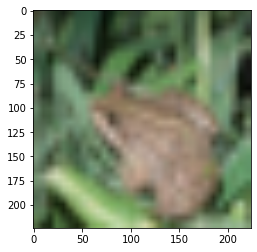

In [45]:
features, targets = next(iter(test_loader))

features = features
targets = targets

np_features = features[4].numpy()
nhwc_img = np.transpose(np_features, axes=(1, 2, 0))
plt.imshow(nhwc_img)

In [47]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
predicted, probability = get_prediction(features[4, None], model)
print('Ground Truth Label',classes[targets[4]])
print('Predicted:', classes[predicted])
print('Probability:', probability[0][predicted]*100)

Ground Truth Label frog
Predicted: frog
Probability: tensor([94.7941], grad_fn=<MulBackward0>)


In [42]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.YlGnBu):
    fig, ax = plt.subplots(figsize=(16,16))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[825  12  50  13   3   2   2   3  71  19]
 [ 19 869  10   3   0   3   7   1  35  53]
 [ 50   3 744  36  31  60  43  15   9   9]
 [ 29   4  80 532  31 205  65  18  24  12]
 [ 24   3 130  44 605  58  64  61   9   2]
 [ 18   2  60  97  26 737  18  27  11   4]
 [  9   2  58  33  10  28 839   3  16   2]
 [ 12   3  50  32  40  48   9 783  11  12]
 [ 37  12  10   9   1   6   2   0 913  10]
 [ 50  65  16   7   3  10   4   9  35 801]]


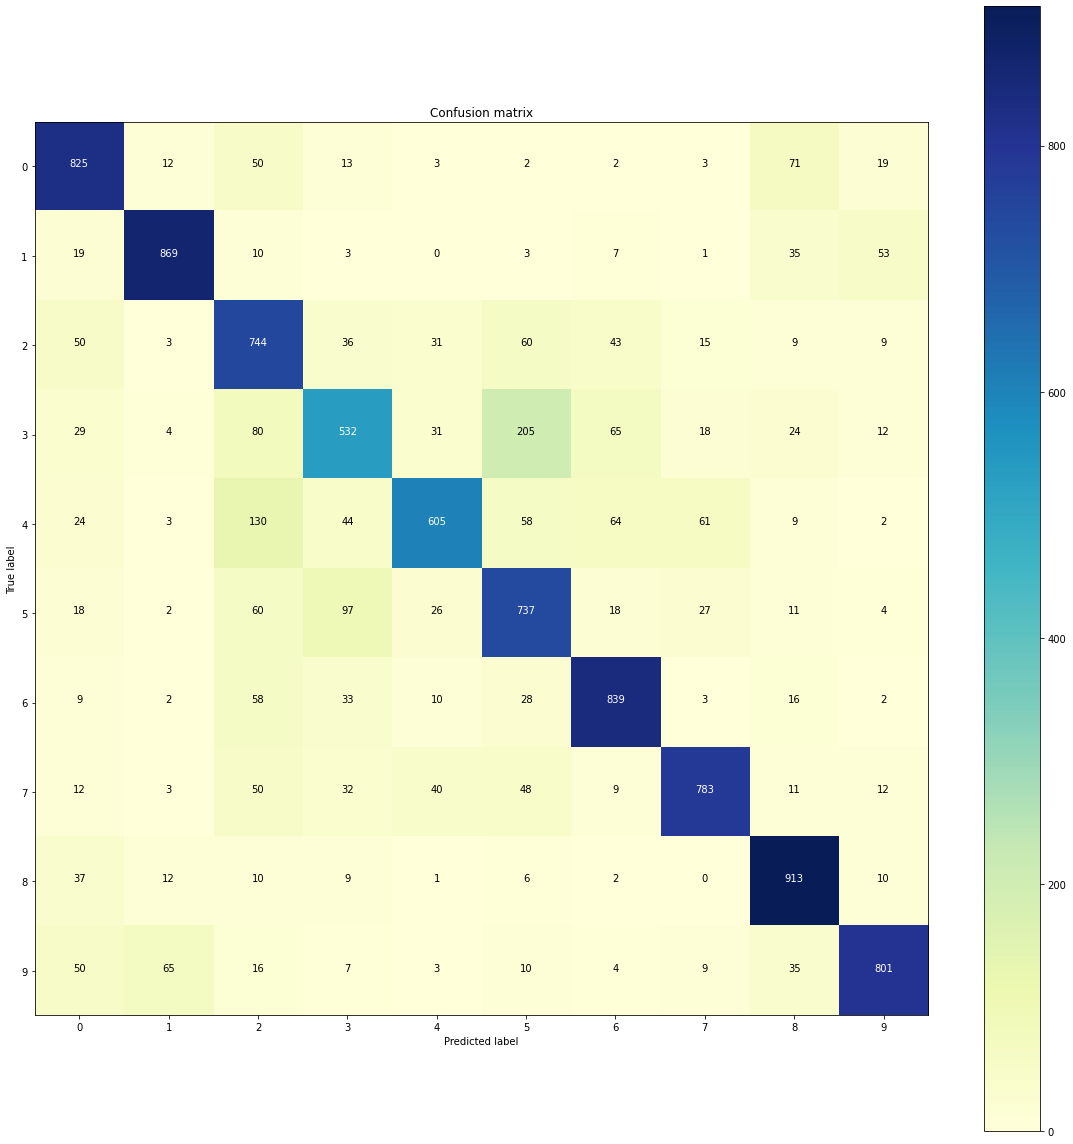

In [43]:
cm = confusion_matrix(true_y, pred_y)
labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
plot_confusion_matrix(cm,labels)